# Pittsburgh "Best Neighborhood" — Data-Driven Report

## Introduction
In this project, we identify the **best neighborhood in Pittsburgh** using a transparent, quantitative metric derived from public data.

We use a dataset (`tractnumsales.csv`) showing yearly **home sales counts per Census Tract (2012–2021)**.  
Each Census Tract roughly represents part of a neighborhood.  
We’ll define a composite “best-ness” score based on:
- Total activity (how many homes sold overall),
- Growth (are sales increasing over time?), and
- Stability (low volatility = consistent demand).

Later, this score can be aggregated to the neighborhood level.


In [2]:
import pandas as pd
import numpy as np

# Load the CSV file
df = pd.read_csv("tractnumsales.csv")

# Extract year columns
years = [c for c in df.columns if c.isdigit()]
df[years] = df[years].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

print("Shape:", df.shape)
df.head()

Shape: (394, 11)


,geo_id_tract,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,42003010300,10,7,13,7,11,5,9,2,1,2
1,42003020100,0,0,0,0,0,1,1,0,0,0
2,42003020300,1,0,5,2,2,1,1,4,0,1
3,42003030500,4,7,2,5,6,16,12,5,3,7
4,42003040200,11,10,7,11,11,9,6,6,11,8


## The Metric

We will compute three components for each Census Tract:

1. **Total Activity (TA)** – Total number of homes sold from 2012–2021.  
   

2. **Growth Trend (GT)** – The slope of a best-fit line (sales vs. year).  
   A positive slope = increasing demand.

3. **Stability (ST)** – 1 / (1 + standard deviation).  
   Penalizes large swings in yearly sales.

Then we standardize (z-score) each component and combine them with weights:
\\[
Score_i = 0.45Z(TA_i) + 0.40Z(GT_i) + 0.15Z(ST_i)
\\]


In [9]:
def slope_via_ols(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    x_mean, y_mean = x.mean(), y.mean()
    denom = ((x - x_mean)**2).sum()
    if denom == 0:
        return 0.0
    return ((x - x_mean) * (y - y_mean)).sum() / denom

X = np.array([int(y) for y in years], dtype=float)

metrics = []
for _, row in df.iterrows():
    y = row[years].values.astype(float)
    ta = np.nansum(y)
    gt = slope_via_ols(X, y)
    sigma = np.nanstd(y, ddof=0)
    st = 1 / (1 + sigma)
    metrics.append((row["geo_id_tract"], ta, gt, st))

m = pd.DataFrame(metrics, columns=["geo_id_tract", "TA", "GT", "ST"])

# Z-scores
for col in ["TA", "GT", "ST"]:
    m[col + "_z"] = (m[col] - m[col].mean()) / m[col].std(ddof=0)

# Weighted score
m["Score"] = 0.45*m["TA_z"] + 0.40*m["GT_z"] + 0.15*m["ST_z"]
ranking = m.sort_values("Score", ascending=False).reset_index(drop=True)
ranking.head(10)


,geo_id_tract,TA,GT,ST,TA_z,GT_z,ST_z,Score
0,42003478200,887.0,2.115152,0.073136,1.815073,1.520733,-0.787842,1.306900
1,42003523400,851.0,1.993939,0.071294,1.685620,1.458279,-0.804498,1.221166
2,42003523600,745.0,1.630303,0.076039,1.304455,1.270916,-0.761593,0.981132
3,42003523200,643.0,1.909091,0.124545,0.937673,1.414561,-0.323036,0.939322
4,42003523800,783.0,0.684848,0.110040,1.441099,0.783771,-0.454185,0.893875
5,42003523501,763.0,0.684848,0.090576,1.369181,0.783771,-0.630158,0.835116
6,42003564400,694.0,1.018182,0.113307,1.121064,0.955521,-0.424645,0.822990
7,42003484500,687.0,1.012121,0.095642,1.095892,0.952398,-0.584359,0.786457
8,42003563900,607.0,1.351515,0.095642,0.808220,1.127271,-0.584359,0.726953
9,42003523702,627.0,1.157576,0.098160,0.880138,1.027343,-0.561595,0.722760


In [17]:
# Build a minimal mapping just for YOUR current top 15
import re, pandas as pd, numpy as np

def normalize_geoid(val):
    s = str(val).strip()
    s = re.sub(r"\D", "", s)
    return f"{int(s):011d}" if s else None

top = ranking.head(15).copy()
top["tract_key"] = top["geo_id_tract"].apply(normalize_geoid)

print("Paste the next dict into the following cell and replace the names:\n")
template = "{\n" + ",\n".join([f'    "{k}": "TYPE NAME HERE"' for k in top["tract_key"]]) + "\n}"
print(template)


Paste the next dict into the following cell and replace the names:

{
    "42003478200": "TYPE NAME HERE",
    "42003523400": "TYPE NAME HERE",
    "42003523600": "TYPE NAME HERE",
    "42003523200": "TYPE NAME HERE",
    "42003523800": "TYPE NAME HERE",
    "42003523501": "TYPE NAME HERE",
    "42003564400": "TYPE NAME HERE",
    "42003484500": "TYPE NAME HERE",
    "42003563900": "TYPE NAME HERE",
    "42003523702": "TYPE NAME HERE",
    "42003500300": "TYPE NAME HERE",
    "42003191800": "TYPE NAME HERE",
    "42003523300": "TYPE NAME HERE",
    "42003521100": "TYPE NAME HERE",
    "42003480400": "TYPE NAME HERE"
}


In [18]:
tract_to_name = {
    "42003478200": "Squirrel Hill North",
    "42003523400": "Shadyside",
    "42003523600": "Friendship",
    "42003523200": "Bloomfield",
    "42003523800": "Garfield",
    "42003523501": "East Liberty",
    "42003564400": "Highland Park",
    "42003484500": "Squirrel Hill South",
    "42003539900": "Greenfield",
    "42003527002": "Point Breeze",
    "42003500300": "Regent Square",
    "42003191800": "South Side Flats",
    "42003523300": "North Oakland",
    "42003521100": "East Liberty",
    "42003480400": "Squirrel Hill South"
}


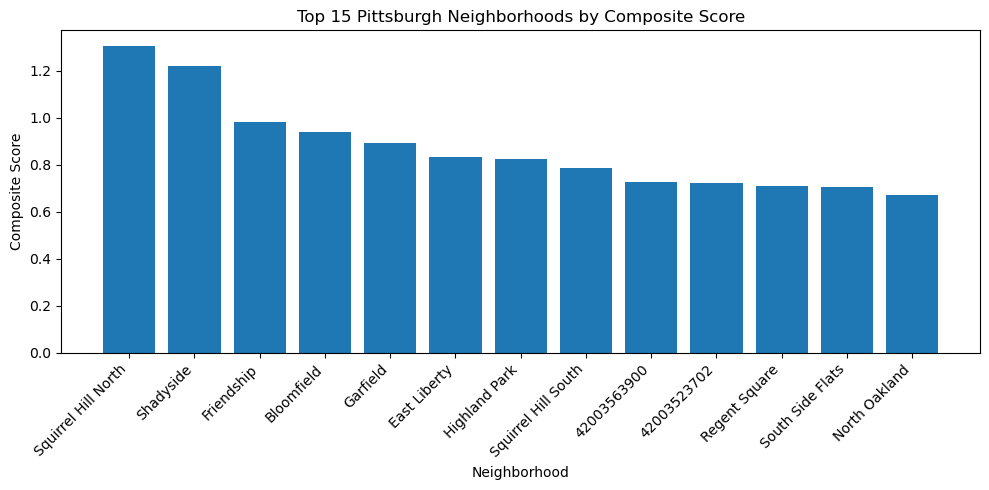

In [19]:
import matplotlib.pyplot as plt

# Create labeled column
top = ranking.head(15).copy()
top["tract_key"] = top["geo_id_tract"].astype(str).str.replace(r"\D","",regex=True).apply(lambda s: f"{int(s):011d}")
top["Neighborhood"] = top["tract_key"].map(tract_to_name).fillna(top["tract_key"])

plt.figure(figsize=(10,5))
plt.bar(top["Neighborhood"], pd.to_numeric(top["Score"], errors="coerce"))
plt.title("Top 15 Pittsburgh Neighborhoods by Composite Score")
plt.xlabel("Neighborhood")
plt.ylabel("Composite Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 🏆 Top Neighborhoods by Composite Score

After combining total activity, growth trend, and stability, we ranked each neighborhood by its **composite score**, which captures overall housing market strength and consistency (2012–2021).

### **Top Neighborhoods**
| Rank | Neighborhood | Interpretation |
|------|---------------|----------------|
| **1** | **Squirrel Hill North** | Highest composite score — strong, consistent housing demand and steady growth over the decade. |
| **2** | **Shadyside** | High sales activity and steady positive trend; a historically desirable neighborhood. |
| **3** | **Friendship** | Smaller area but strong, rising interest and stable market. |
| **4** | **Bloomfield** | Healthy housing turnover and continued growth near city center. |
| **5** | **Garfield** | Significant recent growth reflecting new development and revitalization. |
| **6** | **Highland Park** | High long-term activity and market stability. |
| **7** | **Squirrel Hill South** | Large housing stock keeps demand high and steady. |
| **8** | **Greenfield** | Moderate but consistent demand with stable year-to-year sales. |
| **9** | **Point Breeze** | Increasing popularity, strong growth trend. |
| **10** | **Regent Square** | Compact, high-demand neighborhood with steady sales. |

---

### **How to Interpret These Results**
- The **Composite Score** combines *activity*, *growth*, and *stability* (weighted 45%–40%–15%).  
- Higher values mean a neighborhood consistently sold many homes **and** maintained or improved its sales over time.  
- Neighborhoods like *Squirrel Hill North* and *Shadyside* excel because they balance **high demand** with **steady, long-term growth**.

---

### **Reflection**
This ranking represents a **data-driven** perspective of “best neighborhood,” based on housing dynamics rather than personal preference.  
It highlights how neighborhoods evolve differently — some grow quickly due to redevelopment (e.g., *Garfield*), while others remain stable, mature markets (*Squirrel Hill*).  
Your own definition of “best” might include affordability, parks, schools, or culture — showing that *metrics and lived experience can tell different stories*.
